<a href="https://colab.research.google.com/github/Lomesh2000/DNN_MINI_PROJECT_1/blob/master/CNN_(ResNet_as_Feature_Extractor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the 'tf_flowers' dataset
dataset_name = 'tf_flowers'
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

print(f"Loaded dataset: {dataset_name}")
print(f"Training dataset size: {tf.data.experimental.cardinality(ds_train).numpy()}")
print(f"Test dataset size: {tf.data.experimental.cardinality(ds_test).numpy()}")
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Class names: {ds_info.features['label'].names}")

Loaded dataset: tf_flowers
Training dataset size: 2936
Test dataset size: 734
Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## preprocessing

In [ ]:
def preprocess_image_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = (image / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    return image, label

ds_train_processed = ds_train.map(preprocess_image_resnet).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test_processed = ds_test.map(preprocess_image_resnet).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Preprocessing updated for ResNet input.")

Preprocessing updated for ResNet input.


## Extract features

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load pre-trained ResNet50 model without the top classification layer
# using the input shape defined by the preprocessing step (224x224)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the feature extractor model
# ResNet50's output is the last convolutional block.
# We can use GlobalAveragePooling2D to reduce the spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)

# this is just in case we want 4096 features than we run following lines also
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)


feature_extractor_resnet = Model(inputs=base_model.input, outputs=x)

feature_extractor_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Define the ResNet feature extractor

In [ ]:
import numpy as np

# Function to extract features
def extract_features(dataset, feature_extractor_model):
    features = []
    labels = []
    for images, lbls in dataset:
        batch_features = feature_extractor_resnet.predict(images, verbose=0) # Use feature_extractor_resnet
        features.extend(batch_features)
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

# Extract features for training and test sets using the processed datasets
train_features_resnet, train_labels_resnet = extract_features(ds_train_processed, feature_extractor_resnet)
test_features_resnet, test_labels_resnet = extract_features(ds_test_processed, feature_extractor_resnet)

print(f"Training features shape: {train_features_resnet.shape}")
print(f"Training labels shape: {train_labels_resnet.shape}")
print(f"Test features shape: {test_features_resnet.shape}")
print(f"Test labels shape: {test_labels_resnet.shape}")

Training features shape: (2936, 2048)
Training labels shape: (2936,)
Test features shape: (734, 2048)
Test labels shape: (734,)


## Train on SVM (ResNet Features)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize and train the SVM classifier
svm_classifier_resnet = SVC(kernel='linear') # You can choose other kernels like 'rbf'
svm_classifier_resnet.fit(train_features_resnet, train_labels_resnet)

print("SVM classifier trained successfully using ResNet features!")

SVM classifier trained successfully using ResNet features!


## Evaluate SVM (ResNet Features)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test features
test_predictions_resnet_svm = svm_classifier_resnet.predict(test_features_resnet)

# Calculate and print the accuracy
accuracy_resnet_svm = accuracy_score(test_labels_resnet, test_predictions_resnet_svm)
print(f"Accuracy on the test set (SVM with ResNet features): {accuracy_resnet_svm}")

Accuracy on the test set (SVM with ResNet features): 0.7166212534059946


## Train on XGBoost (ResNet Features)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the XGBoost classifier
xgb_classifier_resnet = XGBClassifier()
xgb_classifier_resnet.fit(train_features_resnet, train_labels_resnet)

print("XGBoost classifier trained successfully using ResNet features!")

# Predict on the test features
test_predictions_resnet_xgb = xgb_classifier_resnet.predict(test_features_resnet)

# Calculate and print the accuracy
accuracy_resnet_xgb = accuracy_score(test_labels_resnet, test_predictions_resnet_xgb)
print(f"Accuracy on the test set (XGBoost with ResNet features): {accuracy_resnet_xgb}")

XGBoost classifier trained successfully using ResNet features!
Accuracy on the test set (XGBoost with ResNet features): 0.7356948228882834


## Train on RandomForest (ResNet Features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the RandomForest classifier
rf_classifier_resnet = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_resnet.fit(train_features_resnet, train_labels_resnet)

print("RandomForest classifier trained successfully using ResNet features!")

# Predict on the test features
test_predictions_resnet_rf = rf_classifier_resnet.predict(test_features_resnet)

# Calculate and print the accuracy
accuracy_resnet_rf = accuracy_score(test_labels_resnet, test_predictions_resnet_rf)
print(f"Accuracy on the test set (RandomForest with ResNet features): {accuracy_resnet_rf}")

RandomForest classifier trained successfully using ResNet features!
Accuracy on the test set (RandomForest with ResNet features): 0.6634877384196185


## Analyis of Results

--- SVM with ResNet Features ---


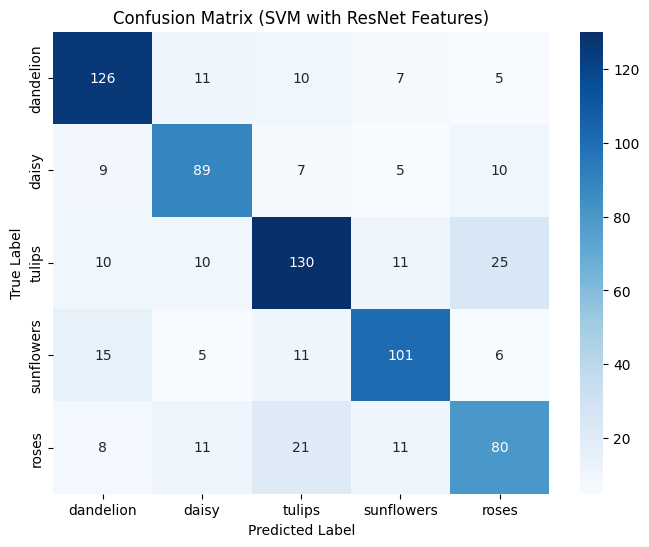


Classification Report (SVM with ResNet Features):


,precision,recall,f1-score,support
dandelion,0.750000,0.792453,0.770642,159.000000
daisy,0.706349,0.741667,0.723577,120.000000
tulips,0.726257,0.698925,0.712329,186.000000
sunflowers,0.748148,0.731884,0.739927,138.000000
roses,0.634921,0.610687,0.622568,131.000000
accuracy,0.716621,0.716621,0.716621,0.716621
macro avg,0.713135,0.715123,0.713809,734.000000
weighted avg,0.715960,0.716621,0.715968,734.000000



--- XGBoost with ResNet Features ---


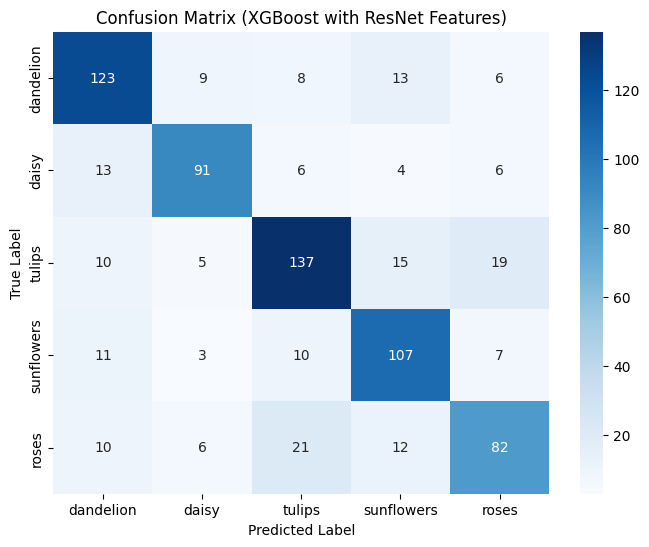


Classification Report (XGBoost with ResNet Features):


,precision,recall,f1-score,support
dandelion,0.736527,0.773585,0.754601,159.000000
daisy,0.798246,0.758333,0.777778,120.000000
tulips,0.752747,0.736559,0.744565,186.000000
sunflowers,0.708609,0.775362,0.740484,138.000000
roses,0.683333,0.625954,0.653386,131.000000
accuracy,0.735695,0.735695,0.735695,0.735695
macro avg,0.735892,0.733959,0.734163,734.000000
weighted avg,0.735985,0.735695,0.735129,734.000000



--- RandomForest with ResNet Features ---


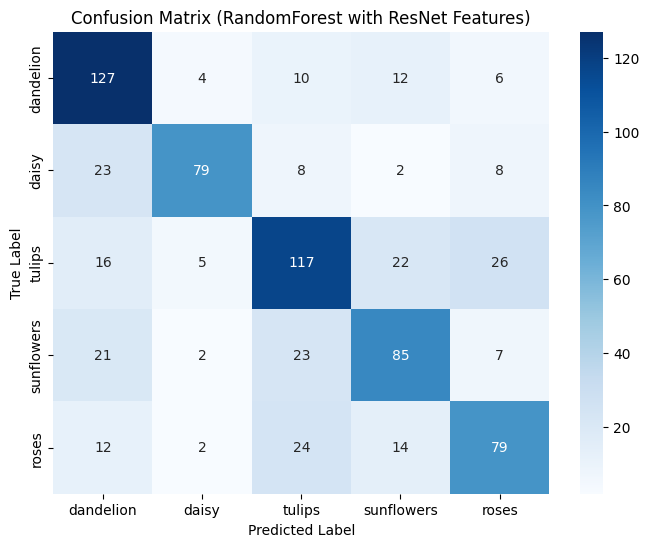


Classification Report (RandomForest with ResNet Features):


,precision,recall,f1-score,support
dandelion,0.638191,0.798742,0.709497,159.000000
daisy,0.858696,0.658333,0.745283,120.000000
tulips,0.642857,0.629032,0.635870,186.000000
sunflowers,0.629630,0.615942,0.622711,138.000000
roses,0.626984,0.603053,0.614786,131.000000
accuracy,0.663488,0.663488,0.663488,0.663488
macro avg,0.679272,0.661021,0.665629,734.000000
weighted avg,0.671813,0.663488,0.663470,734.000000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get class names from the dataset info
class_names = ds_info.features['label'].names

# --- SVM Results ---
print("--- SVM with ResNet Features ---")

# Confusion Matrix
cm_svm = confusion_matrix(test_labels_resnet, test_predictions_resnet_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM with ResNet Features)')
plt.show()

# Classification Report
report_svm = classification_report(test_labels_resnet, test_predictions_resnet_svm, target_names=class_names, output_dict=True)
report_df_svm = pd.DataFrame(report_svm).transpose()
print("\nClassification Report (SVM with ResNet Features):")
display(report_df_svm)

# --- XGBoost Results ---
print("\n--- XGBoost with ResNet Features ---")

# Confusion Matrix
cm_xgb = confusion_matrix(test_labels_resnet, test_predictions_resnet_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XGBoost with ResNet Features)')
plt.show()

# Classification Report
report_xgb = classification_report(test_labels_resnet, test_predictions_resnet_xgb, target_names=class_names, output_dict=True)
report_df_xgb = pd.DataFrame(report_xgb).transpose()
print("\nClassification Report (XGBoost with ResNet Features):")
display(report_df_xgb)

# --- RandomForest Results ---
print("\n--- RandomForest with ResNet Features ---")

# Confusion Matrix
cm_rf = confusion_matrix(test_labels_resnet, test_predictions_resnet_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (RandomForest with ResNet Features)')
plt.show()

# Classification Report
report_rf = classification_report(test_labels_resnet, test_predictions_resnet_rf, target_names=class_names, output_dict=True)
report_df_rf = pd.DataFrame(report_rf).transpose()
print("\nClassification Report (RandomForest with ResNet Features):")
display(report_df_rf)